# Time series forecasting
## Time series forecasting using a number of different architectures such as CNN-1D and RNN-LSTM

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns
sns.set()
sns.set_style("white")

## Preprocessing

In [2]:
df = pd.read_csv("Sunspots.csv", index_col=0)

In [3]:
df.rename(columns={"Monthly Mean Total Sunspot Number": "sunspots"}, inplace=True)

In [4]:
df.drop("Date", inplace=True,axis=1)

In [5]:
df.head()

,sunspots
0,96.7
1,104.3
2,116.7
3,92.8
4,141.7


In [6]:
df.tail()

,sunspots
3260,0.6
3261,14.4
3262,34.0
3263,21.8
3264,10.4


In [7]:
df.describe()

,sunspots
count,3265.000000
mean,81.778775
std,67.889277
min,0.000000
25%,23.900000
50%,67.200000
75%,122.500000
max,398.200000


### Plotting the data

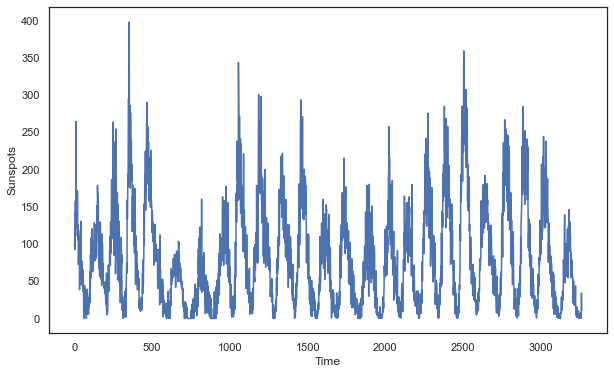

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df["sunspots"])
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.grid = True

### Using the solar cycle and year to give a sense of periodicity using sine and cosine

In [9]:
year = 12
period = 11*year

df['Period sin'] = np.sin(df.index * (2 * np.pi / period))
df['Period cos'] = np.cos(df.index * (2 * np.pi / period))
df['Year sin'] = np.sin(df.index * (2 * np.pi / year))
df['Year cos'] = np.cos(df.index * (2 * np.pi / year))
df.to_csv("sunspots_2.csv", sep=',')
df.head()

,sunspots,Period sin,Period cos,Year sin,Year cos
0,96.7,0.000000,1.000000,0.000000,1.000000e+00
1,104.3,0.047582,0.998867,0.500000,8.660254e-01
2,116.7,0.095056,0.995472,0.866025,5.000000e-01
3,92.8,0.142315,0.989821,1.000000,6.123234e-17
4,141.7,0.189251,0.981929,0.866025,-5.000000e-01


### Visualizing

Text(0.5, 1.0, 'Time of 11 year period signal')

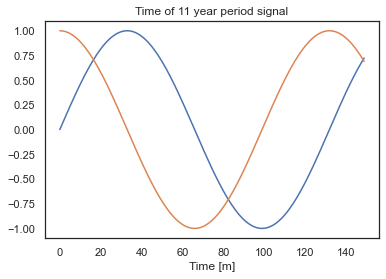

In [10]:
plt.plot(np.array(df['Period sin'])[:150])
plt.plot(np.array(df['Period cos'])[:150])
plt.xlabel('Time [m]')
plt.title('Time of 11 year period signal')

### Splitting dataset between train,validation and test following a (70,20,10) split

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizing the features

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

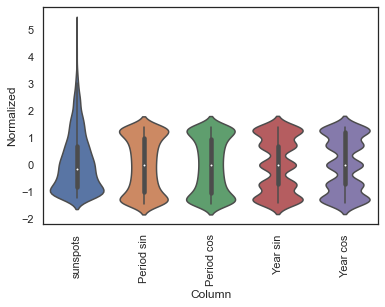

In [14]:
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Window Generator
### Class that generates windows of data to feed to the models

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    # Dunder method
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    # Window Splitting following the given parameters
    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])

      return inputs, labels
    
    # PLotting window data
    def plot(self, model=None, plot_col='sunspots', max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time [m]')
    
    # Convert data to tf.data.Dataset
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)

      return ds
   #Define train val and test splits as tf.data.Datset
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    # Example for easily plotting data
    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

## Function that plots losses

In [16]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.3])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

## Generating 1st window

In [17]:
w1 = WindowGenerator(input_width=10, label_width=1, shift=2,
                     label_columns=['sunspots'])

In [18]:
w1

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [11]
Label column name(s): ['sunspots']

In [19]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Metal device set to: Apple M1
All shapes are: (batch, time, features)
Window shape: (3, 12, 5)
Inputs shape: (3, 10, 5)
Labels shape: (3, 1, 1)


2021-11-10 12:41:36.686006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-10 12:41:36.686115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualizing

2021-11-10 12:41:36.929787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-10 12:41:36.929950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


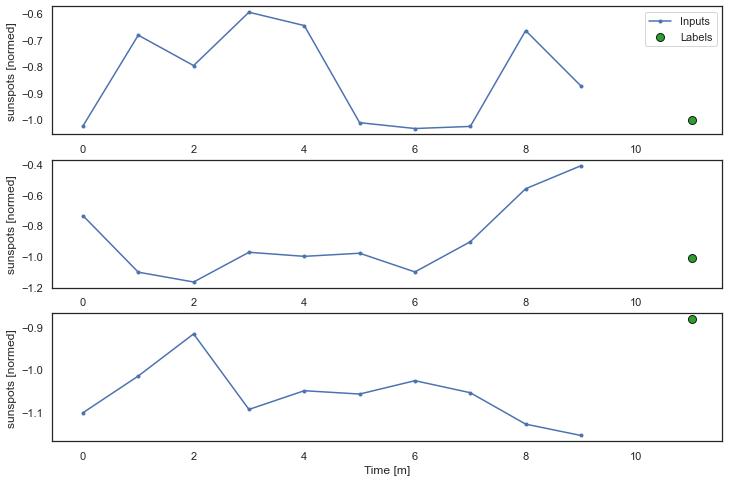

In [20]:
w1.plot()

In [21]:
w1.train.element_spec

(TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [22]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 5)
Labels shape (batch, time, features): (32, 1, 1)


## Function that compiles and fit model

In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    

    model.compile(loss="mean_squared_error",
                    optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                    metrics=["mean_absolute_error"])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      )
  
    return history

## Single step Prediction

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['sunspots'])

In [25]:
# Dictionaries to store validation and train losses for each model
val_performance = {}
performance = {}

### Dense model

#### Architecture and training

In [26]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-10 12:41:37.396127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 1s 9ms/step - loss: 0.4572 - mean_absolute_error: 0.5260 - val_loss: 0.2626 - val_mean_absolute_error: 0.3743
Epoch 2/20
 1/72 [..............................] - ETA: 1s - loss: 0.0820 - mean_absolute_error: 0.2293

2021-11-10 12:41:38.038305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 1s 8ms/step - loss: 0.2092 - mean_absolute_error: 0.3352 - val_loss: 0.2261 - val_mean_absolute_error: 0.3438
Epoch 3/20
72/72 [==============================] - 1s 8ms/step - loss: 0.1923 - mean_absolute_error: 0.3167 - val_loss: 0.2153 - val_mean_absolute_error: 0.3330
Epoch 4/20
72/72 [==============================] - 1s 8ms/step - loss: 0.1834 - mean_absolute_error: 0.3084 - val_loss: 0.2123 - val_mean_absolute_error: 0.3307
Epoch 5/20
72/72 [==============================] - 1s 8ms/step - loss: 0.1806 - mean_absolute_error: 0.3043 - val_loss: 0.1990 - val_mean_absolute_error: 0.3233
Epoch 6/20
72/72 [==============================] - 1s 8ms/step - loss: 0.1794 - mean_absolute_error: 0.3014 - val_loss: 0.2142 - val_mean_absolute_error: 0.3317
Epoch 7/20
72/72 [==============================] - 1s 8ms/step - loss: 0.1774 - mean_absolute_error: 0.2997 - val_loss: 0.2035 - val_mean_absolute_error: 0.3248
Epoch 8/20
72/72 [=====================

#### Prediction plot

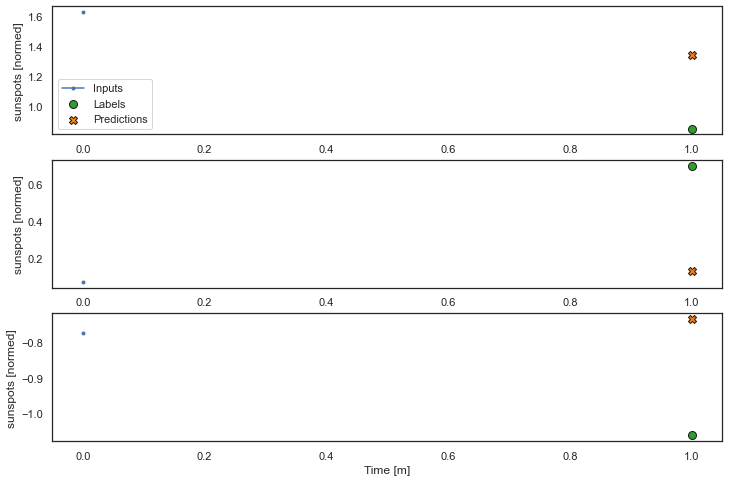

In [27]:
single_step_window.plot(dense)

#### Losses

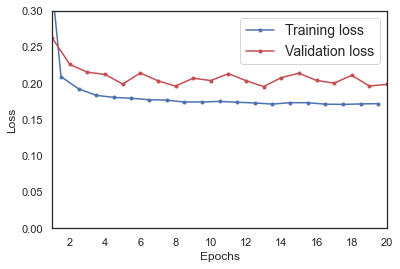

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Dense model which receives multiple steps

#### Defining larger window

In [29]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['sunspots'])

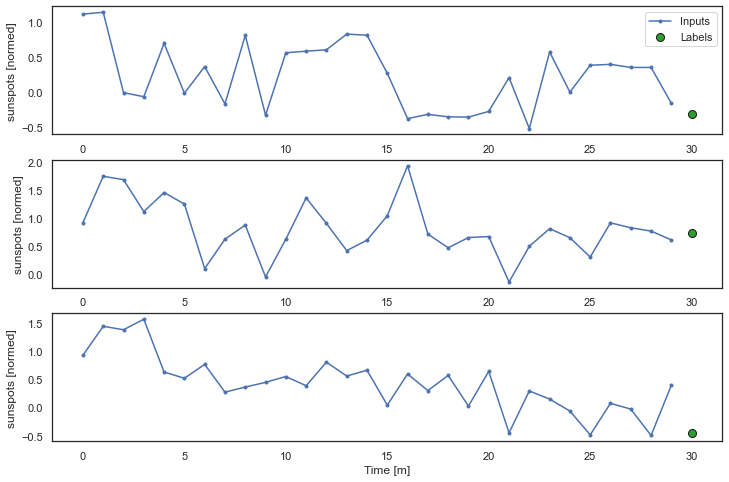

In [30]:
conv_window.plot()

#### Architecture and training

In [31]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [32]:
history = compile_and_fit(multi_step_dense, conv_window)


val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-10 12:41:51.226970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
71/71 [==============================] - 1s 6ms/step - loss: 0.8199 - mean_absolute_error: 0.6612 - val_loss: 0.3365 - val_mean_absolute_error: 0.4350
Epoch 2/20
24/71 [=========>....................] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3797

2021-11-10 12:41:51.613155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 0s 5ms/step - loss: 0.2421 - mean_absolute_error: 0.3667 - val_loss: 0.2629 - val_mean_absolute_error: 0.3942
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2024 - mean_absolute_error: 0.3366 - val_loss: 0.2494 - val_mean_absolute_error: 0.3926
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1842 - mean_absolute_error: 0.3196 - val_loss: 0.2326 - val_mean_absolute_error: 0.3793
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1743 - mean_absolute_error: 0.3106 - val_loss: 0.2326 - val_mean_absolute_error: 0.3790
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1663 - mean_absolute_error: 0.3025 - val_loss: 0.2247 - val_mean_absolute_error: 0.3698
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1606 - mean_absolute_error: 0.2970 - val_loss: 0.2215 - val_mean_absolute_error: 0.3619
Epoch 8/20
71/71 [=====================

#### Prediction plot

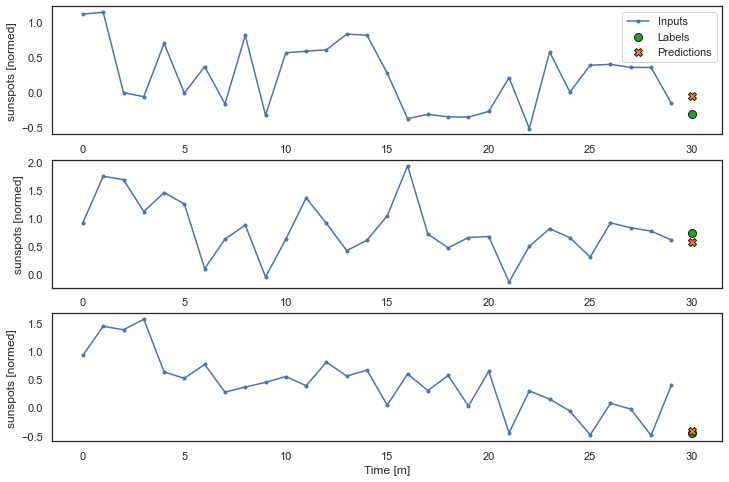

In [33]:
conv_window.plot(multi_step_dense)

#### Losses

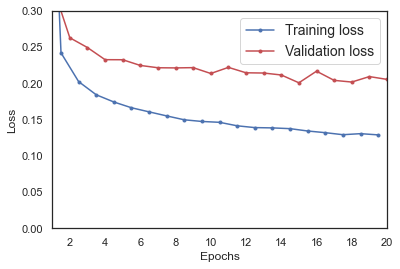

In [34]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 1D Convolutional model

#### Architecture and training

In [35]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [36]:
history = compile_and_fit(conv_model, conv_window)


val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-10 12:41:59.528523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
71/71 [==============================] - 1s 9ms/step - loss: 0.5385 - mean_absolute_error: 0.5336 - val_loss: 0.3115 - val_mean_absolute_error: 0.4222
Epoch 2/20
 8/71 [==>...........................] - ETA: 0s - loss: 0.2469 - mean_absolute_error: 0.3730

2021-11-10 12:42:00.104382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 8ms/step - loss: 0.2148 - mean_absolute_error: 0.3443 - val_loss: 0.2150 - val_mean_absolute_error: 0.3528
Epoch 3/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1804 - mean_absolute_error: 0.3126 - val_loss: 0.2052 - val_mean_absolute_error: 0.3445
Epoch 4/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1683 - mean_absolute_error: 0.3017 - val_loss: 0.1964 - val_mean_absolute_error: 0.3341
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1627 - mean_absolute_error: 0.2955 - val_loss: 0.1863 - val_mean_absolute_error: 0.3291
Epoch 6/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1549 - mean_absolute_error: 0.2881 - val_loss: 0.1827 - val_mean_absolute_error: 0.3255
Epoch 7/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1534 - mean_absolute_error: 0.2882 - val_loss: 0.1882 - val_mean_absolute_error: 0.3233
Epoch 8/20
71/71 [=====================

#### Prediction plot

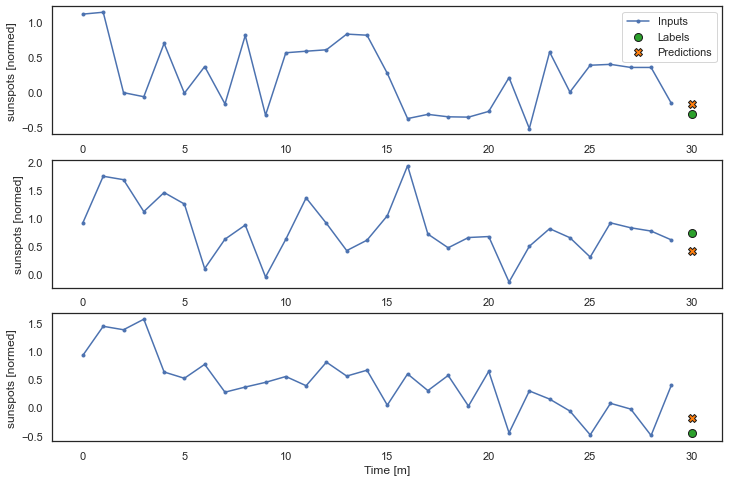

In [37]:
conv_window.plot(conv_model)

#### Losses

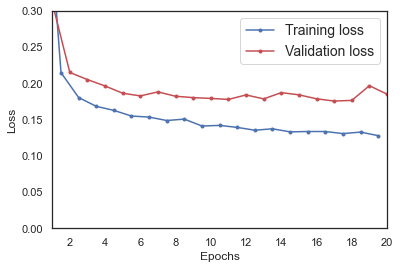

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Defining Larger convolutional window

In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['sunspots'])

wide_conv_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['sunspots']

### using 1D convolutional model on wider window

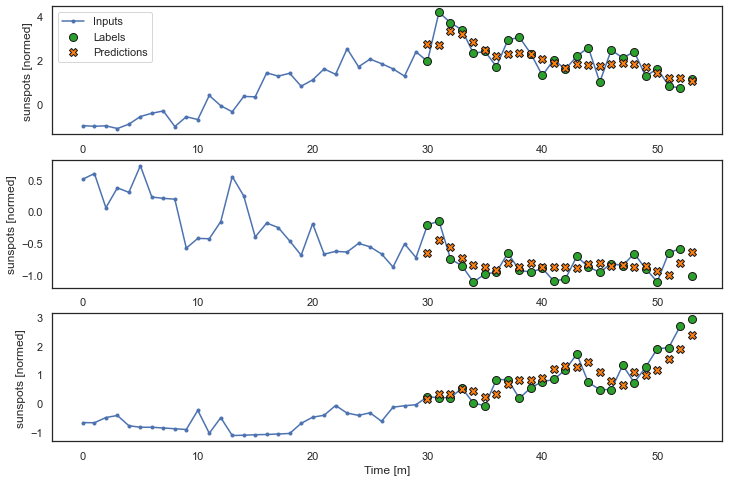

In [40]:
wide_conv_window.plot(conv_model)

#### Losses

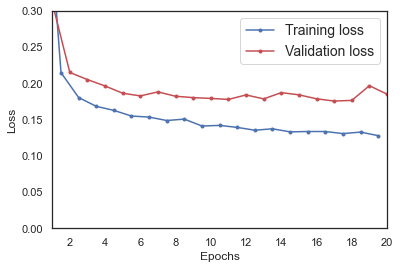

In [41]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### LSTM model

#### Creating wide window

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['sunspots'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['sunspots']

#### Architecture and training

In [43]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [44]:
history = compile_and_fit(lstm_model, wide_window)


val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20


2021-11-10 12:42:13.614041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:13.754093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:13.806742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:13.852739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:13.922587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:14.011974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/71 [>.............................] - ETA: 2s - loss: 0.9058 - mean_absolute_error: 0.7616  

2021-11-10 12:42:14.091933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 0.6399 - mean_absolute_error: 0.6072

2021-11-10 12:42:16.560871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:16.617930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:16.659626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:42:16.700985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 5s 41ms/step - loss: 0.6399 - mean_absolute_error: 0.6072 - val_loss: 0.7074 - val_mean_absolute_error: 0.6247
Epoch 2/20
71/71 [==============================] - 2s 31ms/step - loss: 0.3740 - mean_absolute_error: 0.4447 - val_loss: 0.4595 - val_mean_absolute_error: 0.4909
Epoch 3/20
71/71 [==============================] - 2s 31ms/step - loss: 0.2950 - mean_absolute_error: 0.3916 - val_loss: 0.3857 - val_mean_absolute_error: 0.4517
Epoch 4/20
71/71 [==============================] - 2s 30ms/step - loss: 0.2697 - mean_absolute_error: 0.3733 - val_loss: 0.3538 - val_mean_absolute_error: 0.4316
Epoch 5/20
71/71 [==============================] - 2s 32ms/step - loss: 0.2562 - mean_absolute_error: 0.3629 - val_loss: 0.3298 - val_mean_absolute_error: 0.4191
Epoch 6/20
71/71 [==============================] - 2s 32ms/step - loss: 0.2446 - mean_absolute_error: 0.3546 - val_loss: 0.3130 - val_mean_absolute_error: 0.4081
Epoch 7/20
71/71 [===============

#### Losses

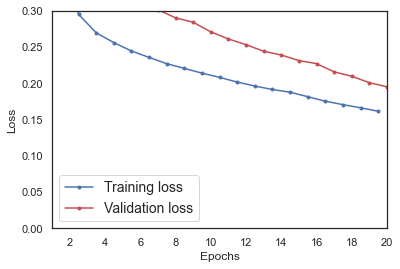

In [45]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Comparing the performance of the models

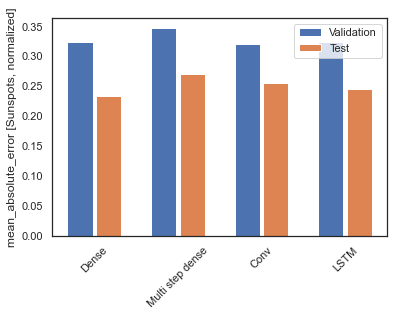

In [46]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Sunspots, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [47]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Dense       : 0.2340
Multi step dense: 0.2699
Conv        : 0.2545
LSTM        : 0.2454


## Multi Step prediction

### Defining Window and visualizing

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

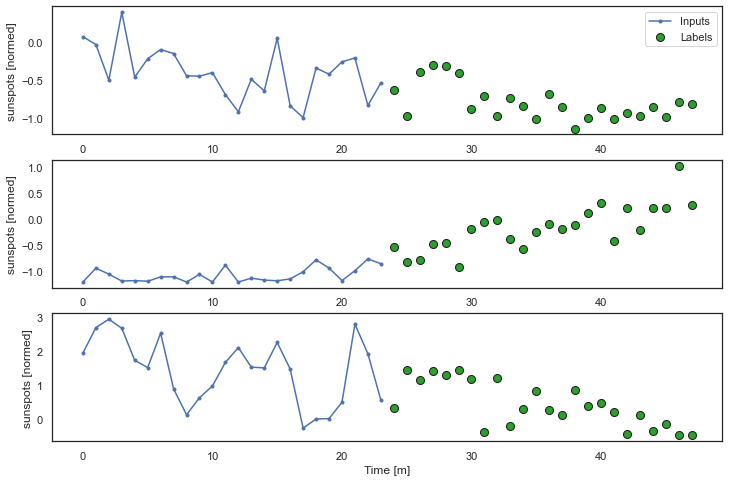

In [48]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [49]:
# Dictionaries to store validation and train losses for each model
multi_val_performance = {}
multi_performance = {}

### Dense model for multi step prediction

#### Architecture and training

In [50]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)


multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)


/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-10 12:43:00.095163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 0.5672 - mean_absolute_error: 0.6286 - val_loss: 0.2314 - val_mean_absolute_error: 0.3404
Epoch 2/20
11/70 [===>..........................] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.2937

2021-11-10 12:43:00.610960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 7ms/step - loss: 0.1123 - mean_absolute_error: 0.1729 - val_loss: 0.1375 - val_mean_absolute_error: 0.1387
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 0.0937 - mean_absolute_error: 0.1144 - val_loss: 0.1323 - val_mean_absolute_error: 0.1319
Epoch 4/20
70/70 [==============================] - 1s 7ms/step - loss: 0.0926 - mean_absolute_error: 0.1103 - val_loss: 0.1389 - val_mean_absolute_error: 0.1320
Epoch 5/20
70/70 [==============================] - 1s 7ms/step - loss: 0.0924 - mean_absolute_error: 0.1088 - val_loss: 0.1330 - val_mean_absolute_error: 0.1286
Epoch 6/20
70/70 [==============================] - 1s 7ms/step - loss: 0.0916 - mean_absolute_error: 0.1074 - val_loss: 0.1333 - val_mean_absolute_error: 0.1275
Epoch 7/20
70/70 [==============================] - 0s 7ms/step - loss: 0.0919 - mean_absolute_error: 0.1070 - val_loss: 0.1328 - val_mean_absolute_error: 0.1267
Epoch 8/20
70/70 [=====================

#### Prediction plot

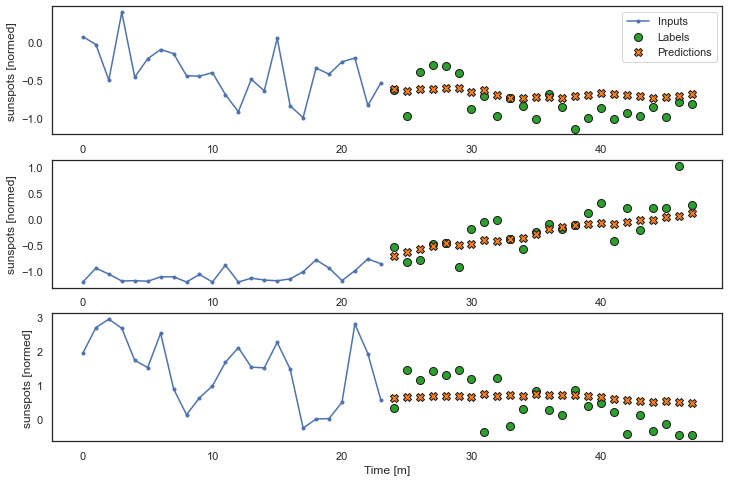

In [51]:
multi_window.plot(multi_dense_model)

#### Losses

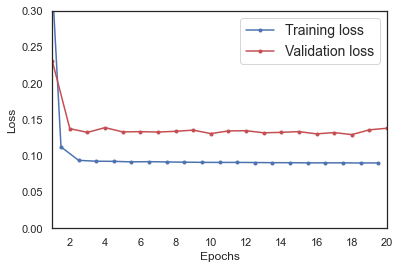

In [52]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Multi Step 1D Convolutional Network

#### Architecture and Training

In [53]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)



multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)


/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-10 12:43:11.045961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 0.6087 - mean_absolute_error: 0.6547 - val_loss: 0.2517 - val_mean_absolute_error: 0.3520
Epoch 2/20
12/70 [====>.........................] - ETA: 0s - loss: 0.1913 - mean_absolute_error: 0.3126

2021-11-10 12:43:11.550648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 6ms/step - loss: 0.1214 - mean_absolute_error: 0.1854 - val_loss: 0.1338 - val_mean_absolute_error: 0.1398
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0924 - mean_absolute_error: 0.1153 - val_loss: 0.1299 - val_mean_absolute_error: 0.1324
Epoch 4/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0909 - mean_absolute_error: 0.1102 - val_loss: 0.1261 - val_mean_absolute_error: 0.1282
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0907 - mean_absolute_error: 0.1087 - val_loss: 0.1287 - val_mean_absolute_error: 0.1275
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0901 - mean_absolute_error: 0.1067 - val_loss: 0.1265 - val_mean_absolute_error: 0.1256
Epoch 7/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0897 - mean_absolute_error: 0.1063 - val_loss: 0.1292 - val_mean_absolute_error: 0.1263
Epoch 8/20
70/70 [=====================

#### Prediction plot

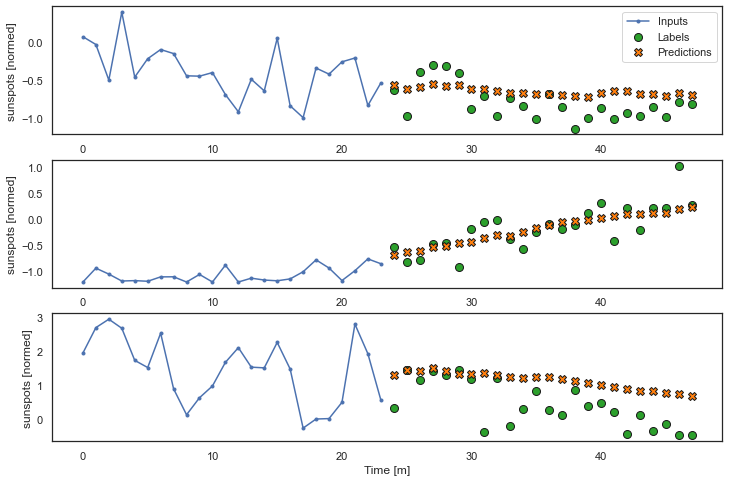

In [54]:
multi_window.plot(multi_conv_model)

#### Losses

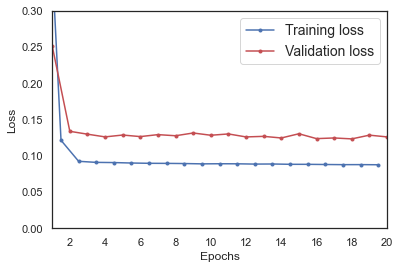

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Multi Step LSTM Model

#### Architecture and training

In [56]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)



multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)


/Users/miguel/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20


2021-11-10 12:43:20.888665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:43:20.954733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:43:21.021378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 0.9124 - mean_absolute_error: 0.8317

2021-11-10 12:43:22.265082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-10 12:43:22.294130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 2s 20ms/step - loss: 0.9124 - mean_absolute_error: 0.8317 - val_loss: 0.9282 - val_mean_absolute_error: 0.8188
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 0.6667 - mean_absolute_error: 0.6866 - val_loss: 0.6701 - val_mean_absolute_error: 0.6467
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 0.4908 - mean_absolute_error: 0.5556 - val_loss: 0.4920 - val_mean_absolute_error: 0.5274
Epoch 4/20
70/70 [==============================] - 1s 16ms/step - loss: 0.2976 - mean_absolute_error: 0.4199 - val_loss: 0.2771 - val_mean_absolute_error: 0.3466
Epoch 5/20
70/70 [==============================] - 1s 16ms/step - loss: 0.1603 - mean_absolute_error: 0.2523 - val_loss: 0.2063 - val_mean_absolute_error: 0.2366
Epoch 6/20
70/70 [==============================] - 1s 15ms/step - loss: 0.1264 - mean_absolute_error: 0.1872 - val_loss: 0.1855 - val_mean_absolute_error: 0.2099
Epoch 7/20
70/70 [===============

#### Prediction Plot

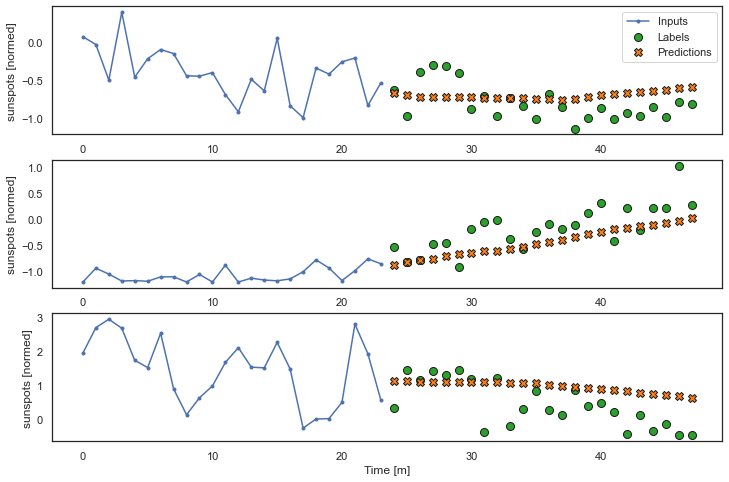

In [57]:
multi_window.plot(multi_lstm_model)

#### Losses

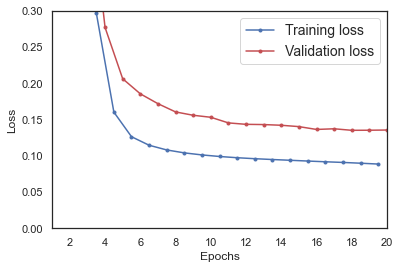

In [58]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Comparing Multi step models

In [59]:
multi_val_performance

{'Dense': [0.13805444538593292, 0.12783539295196533],
 'Conv': [0.12610134482383728, 0.12440934032201767],
 'LSTM': [0.13558942079544067, 0.16602492332458496]}

In [60]:
df

,sunspots,Period sin,Period cos,Year sin,Year cos
0,96.7,0.000000,1.000000,0.000000e+00,1.000000e+00
1,104.3,0.047582,0.998867,5.000000e-01,8.660254e-01
2,116.7,0.095056,0.995472,8.660254e-01,5.000000e-01
3,92.8,0.142315,0.989821,1.000000e+00,6.123234e-17
4,141.7,0.189251,0.981929,8.660254e-01,-5.000000e-01
...,...,...,...,...,...
3260,0.6,-0.945001,-0.327068,-8.660254e-01,-5.000000e-01
3261,14.4,-0.959493,-0.281733,-1.000000e+00,-1.180739e-13
3262,34.0,-0.971812,-0.235759,-8.660254e-01,5.000000e-01
3263,21.8,-0.981929,-0.189251,-5.000000e-01,8.660254e-01
